### 언어 모델 설정하기

In [3]:
from langchain_openai import ChatOpenAI
import os
import dotenv

# .env에서 api 키 가져오기
dotenv.load_dotenv()

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.01, api_key=os.getenv("OPENAI_API_KEY"))
model.invoke("안녕하세요")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d77b305a29', 'id': 'chatcmpl-CBb800oQZOLN9a7vKCWHy0JMNz3XM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f1996e78-0b76-4e20-8202-2da200257f2a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### 상태 설정하기

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
        주석에 있는 'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다.)
    """
    messages: Annotated[list[str], add_messages]

# StateGraph 클래스를 사용하여 State 타입의 그래프 생성
graph_builder = StateGraph(State)

### 도구 등록하기

In [5]:
from langchain_core.tools import tool
from datetime import datetime
import pytz
from langchain_community.utilities import SerpAPIWrapper
from dotenv import load_dotenv
import os

# .env 키 값 가져오기
load_dotenv()
SERP_API_KEY = os.getenv("SERP_API_KEY")

import bs4
from langchain_community.document_loaders import WebBaseLoader

# 도구 함수 정의
@tool
def get_current_time(timezone: str, location: str) -> str:
    """현재 시각을 반환하는 함수"""
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        result = f'{timezone} ({location}) 현재 시각 {now}'

        return result
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"

@tool
def get_web_search(query: str, search_period: str='m')-> str:
    """
    웹 검색을 수행하는 함수 (SerpAPI 사용)
    
    Args:
        query (str): 검색어
        search_period (str): 검색 기간(e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)
    
    Returns:
        str: 검색 결과
    """
    try:
        # API 키 확인
        if not SERP_API_KEY:
            return "SERP_API_KEY가 설정되지 않았습니다. .env 파일에 SERP_API_KEY를 추가하세요."
        
        # SerpAPI 사용 (API 키 전달)
        serpapi_wrapper = SerpAPIWrapper(serpapi_api_key=SERP_API_KEY)
        
        print('\n-------WEB SEARCH-------')
        print(f'검색어: {query}')
        print(f'검색 기간: {search_period}')
        
        # SerpAPI로 검색 실행
        results = serpapi_wrapper.run(query)
        
        print(f'검색 결과: {results}')
        return results
        
    except Exception as e:
        error_msg = f"검색 중 오류 발생: {str(e)}"
        print(error_msg)
        return error_msg

# 도구 바인딩
tools = [get_current_time, get_web_search]

USER_AGENT environment variable not set, consider setting it to identify your requests.


### 현재 시각을 얻는 도구 get_current_time 실행 테스트하기

In [6]:
tools[0].invoke({"timezone": "Asia/Seoul", "location": "서울"})

'Asia/Seoul (서울) 현재 시각 2025-09-03 15:19:27'

### 웹 검색 도구 get_web_search 실행 테스트하기

In [7]:
tools[1].invoke({"query": "파이썬", "search_period": "m"})


-------WEB SEARCH-------
검색어: 파이썬
검색 기간: m
검색 결과: ['Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation. Python is dynamically type-checked and garbage-collected.', 'Python (파이썬) type: High-level programming language.', 'Python (파이썬) kgmid: /m/05z1_.', 'Python (파이썬) designed_by: Guido van Rossum.', 'Python (파이썬) developer: Python Software Foundation.', 'Python (파이썬) first_appeared: 20 February 1991; 34 years ago.', 'Python (파이썬) paradigm: Multi-paradigm - object-oriented, procedural (imperative), functional, structured, reflective.', 'Python (파이썬) stable_release: 3.13.7 / 14 August 2025; 17 days ago.', 'Python (파이썬) typing_discipline: duck, dynamic, strong; optional type annotations.', '파이썬은 멀티 패러다임 언어로, 절차적 프로그래밍, 함수형 프로그래밍, 객체 지향 등 다양한 패러다임을 모두 지원하는 언어이다. 속도에서 약간의 희생 ...', 'Python is a programming language that lets you work quickly and integrate systems more effectively. Learn More',

"['Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation. Python is dynamically type-checked and garbage-collected.', 'Python (파이썬) type: High-level programming language.', 'Python (파이썬) kgmid: /m/05z1_.', 'Python (파이썬) designed_by: Guido van Rossum.', 'Python (파이썬) developer: Python Software Foundation.', 'Python (파이썬) first_appeared: 20 February 1991; 34 years ago.', 'Python (파이썬) paradigm: Multi-paradigm - object-oriented, procedural (imperative), functional, structured, reflective.', 'Python (파이썬) stable_release: 3.13.7 / 14 August 2025; 17 days ago.', 'Python (파이썬) typing_discipline: duck, dynamic, strong; optional type annotations.', '파이썬은 멀티 패러다임 언어로, 절차적 프로그래밍, 함수형 프로그래밍, 객체 지향 등 다양한 패러다임을 모두 지원하는 언어이다. 속도에서 약간의 희생 ...', 'Python is a programming language that lets you work quickly and integrate systems more effectively. Learn More', 'The official home of the Python Programming Lang

### 도구 목록 확인하기

In [8]:
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시각을 반환하는 함수' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x000002006501B560>
get_web_search name='get_web_search' description='웹 검색을 수행하는 함수 (SerpAPI 사용)\n\nArgs:\n    query (str): 검색어\n    search_period (str): 검색 기간(e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)\n\nReturns:\n    str: 검색 결과' args_schema=<class 'langchain_core.utils.pydantic.get_web_search'> func=<function get_web_search at 0x0000020069B56660>


### 언어 모델에 .bind_tools로 사용할 도구 연결하기

In [9]:
model_with_tools = model.bind_tools(tools)

def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리
        형식은 {"messages": [응답 메시지]} 입니다.
    """
    return {"messages": model_with_tools.invoke(state["messages"])}

graph_builder.add_node("generate", generate)

### 도구를 사용하는 노드 클래스 생성하기

In [12]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
    도구를 실행하는 노드 클래스입니다. 마지막 AIMessage에서 요청된 도구를 실행합니다.
    Attributes:
        tools_by_name (dict): 도구 이름을 키로 하고 도구 객체를 값으로 가지는 사전입니다.
    Methods:
        __init__(tools:list): 도구 객체들의 리스트를 받아서 초기화합니다.
        __call__(inputs: dict): 입력 메시지를 받아서 도구를 실행하고 결과 메시지를 반환합니다.
    """
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            # inputs에 messages가 있으면 messages를 가져오고 없으면 빈 리스트 가져오기
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs=[]
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )
        return {"messages": messages + outputs}

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

### 언어 모델이 도구 사용 여부를 판단하도록 라우터 설정하기

In [13]:
def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 끝으로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_edge(START, "generate")

graph_builder.add_conditional_edges(
    "generate",
    route_tools,
    {"tools": "tools", END: END},
)
# 도구가 호출될 때마다 다음 단꼐를 결정하기 위해 챗봇으로 돌아감
graph_builder.add_edge("tools", "generate")
graph = graph_builder.compile()

### 그래프 출력하기

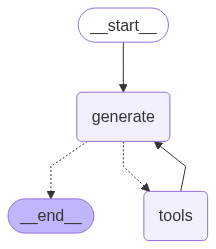

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 답변 출력하기

In [15]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="지금 부산 몇 시야?")]

gathered = None
for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')

        if gathered is None:
            gathered = msg
        else:
            gathered = gathered + msg

gathered

현재 부산은 2025년 9월 3일 오후 3시 33분입니다.

AIMessageChunk(content='현재 부산은 2025년 9월 3일 오후 3시 33분입니다.', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_tKYTIQMVO4qiSW3m07tvP2zR', 'function': {'arguments': '{"timezone":"Asia/Seoul","location":"Busan"}', 'name': 'get_current_time'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_callsstop', 'model_name': 'gpt-4o-mini-2024-07-18gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2cfp_8bda4d3a2c', 'service_tier': 'defaultdefault'}, id='run--626b7dc9-1460-402b-9895-f994733fde54', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Asia/Seoul', 'location': 'Busan'}, 'id': 'call_tKYTIQMVO4qiSW3m07tvP2zR', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'get_current_time', 'args': '{"timezone":"Asia/Seoul","location":"Busan"}', 'id': 'call_tKYTIQMVO4qiSW3m07tvP2zR', 'index': 0, 'type': 'tool_call_chunk'}])

### 프롬프트 설정하고 기사 작성하기

In [17]:
from langchain_core.messages import AIMessageChunk, SystemMessage

about = "닌텐도 게임 '스플래툰'의 진입장벽 및 플레이의 어려움"

inputs = [SystemMessage(content=f"""
너는 신문기자이다.
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다.

- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘.
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐
- 검색할 리스트를 토대로 재검색해.
- 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해.
- 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋아.

더이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성한다.
제목, 부제, 리드문, 본문의 구성으로 작성한다. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이있게 작성해야 한다.

""")]

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')


-------WEB SEARCH-------
검색어: Splatoon game difficulty criticism
검색 기간: m
검색 결과: ["They're unbalanced and tedious. The Splatoon 2 bosses were an ideal difficulty curve for learning mechanics while Splatoon 3 bosses seem ...", "In my opinion splatoon isn't hard, there's just a lot you can do, and a lot that's out of your control. Getting good at a weapon and reaching ...", "Splatoon 3 is here and critics are all saying the same thing: it's great! Here's what early reactions to the latest game reveal.", 'Splatoon 2, released to criticism about its lack of content. But how is Splatoon 2 now? The game now has 62 weapons, 14 stages with 2 more on ...', "A couple of weeks ago, I described Splatoon 3 as a 'difficult game to preview', largely because of its iterative nature."]
최근 '스플래툰' 시리즈에 대한 비판이 주목받고 있습니다. 특히, '스플래툰 3'의 난이도와 진입 장벽에 대한 논의가 활발히 이루어지고 있습니다. 많은 플레이어들이 게임의 복잡한 메커니즘과 다양한 무기 시스템으로 인해 초보자들이 접근하기 어렵다는 의견을 내고 있습니다. 이러한 주제를 선정한 이유는, 게임의 인기가 높아짐에 따라 더 많은 신규 플레이어가 유입되고 있지만, 그들이 겪는 어려움이